In [ ]:
n=60 # 5ans de données mensuelles 5*12
t=np.arange(n)
beta0=100 #Ordonnée à l'origine
beta1=2 #pente de la tendance
A=20 #amplitude de la saisonnalité
P=12 # période de la saisonnalité
sigma = 5


# Génération des composants
trend= beta0 + beta1 + t
seasonality = A*np.sin(2*np.pi*t/P)
noise = np.random.normal(0, sigma, n)

# Création de la série temporelle
sales = trend + seasonality + noise

dates = pd.date_range(start='2019-01', periods=n, freq='M')
df = pd.DataFrame({
    'Date': dates,
    'Sales': sales,
    'Trend': trend,
    'Seasonality': seasonality,
    'Noise': noise
})
df.set_index('Date', inplace=True)
fig, axes = plt.subplots(5, 1, figsize=(15, 12))

# Série complète
axes[0].plot(df.index, df['Sales'], color='navy', linewidth=2)
axes[0].set_title('Série Temporelle Complète (Sales)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Valeur')
axes[0].grid(True, alpha=0.3)

# Tendance
axes[1].plot(df.index, df['Trend'], color='red', linewidth=2)
axes[1].set_title('Composante de Tendance', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Tendance')
axes[1].grid(True, alpha=0.3)

# Saisonnalité
axes[2].plot(df.index, df['Seasonality'], color='green', linewidth=2)
axes[2].set_title('Composante Saisonnière', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Saisonnalité')
axes[2].grid(True, alpha=0.3)

# Bruit
axes[3].plot(df.index, df['Noise'], color='orange', linewidth=1)
axes[3].set_title('Bruit (Résidus)', fontsize=14, fontweight='bold')
axes[3].set_ylabel('Bruit')
axes[3].grid(True, alpha=0.3)

# Série décomposée (superposition)
axes[4].plot(df.index, df['Sales'], label='Série Complète', color='navy', linewidth=2)
axes[4].plot(df.index, df['Trend'], label='Tendance', color='red', linewidth=1.5, linestyle='--')
axes[4].set_title('Série Complète vs Tendance', fontsize=14, fontweight='bold')
axes[4].set_ylabel('Valeur')
axes[4].set_xlabel('Date')
axes[4].legend()
axes[4].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("="*60)
print("STATISTIQUES DESCRIPTIVES")
print("="*60)
print(df.describe())

In [44]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test on the 'y' column
adf_test = adfuller(df['Sales'])

# Extract and print the results
adf_statistic = adf_test[0]
p_value = adf_test[1]
critical_values = adf_test[4]

print(f'ADF Statistic: {adf_statistic}')
print(f'P-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'\t{key}: {value}')

# Interpret the results
if p_value <= 0.05:
    print("Result: The time series is likely stationary (reject the null hypothesis)")
else:
    print("Result: The time series is likely non-stationary (fail to reject the null hypothesis)")

ADF Statistic: 0.4324232911694006
P-value: 0.9826677918610464
Critical Values:
	1%: -3.568485864
	5%: -2.92135992
	10%: -2.5986616
Result: The time series is likely non-stationary (fail to reject the null hypothesis)


In [8]:
from statsmodels.tsa.stattools import adfuller

adf_test_diff = adfuller(df['y_diff'])

adf_statistic_diff = adf_test_diff[0]
p_value_diff = adf_test_diff[1]
critical_values_diff = adf_test_diff[4]

print(f'ADF Statistic (Differenced Series): {adf_statistic_diff}')
print(f'P-value (Differenced Series): {p_value_diff}')
print('Critical Values (Differenced Series):')
for key, value in critical_values_diff.items():
    print(f'\t{key}: {value}')

if p_value_diff <= 0.05:
    print("✅ The differenced series is likely stationary.")
else:
    print("⚠️ The differenced series is likely non-stationary.")


ADF Statistic (Differenced Series): -5.682038529982299
P-value (Differenced Series): 8.442839841363024e-07
Critical Values (Differenced Series):
	1%: -3.5745892596209488
	5%: -2.9239543084490744
	10%: -2.6000391840277777
✅ The differenced series is likely stationary.


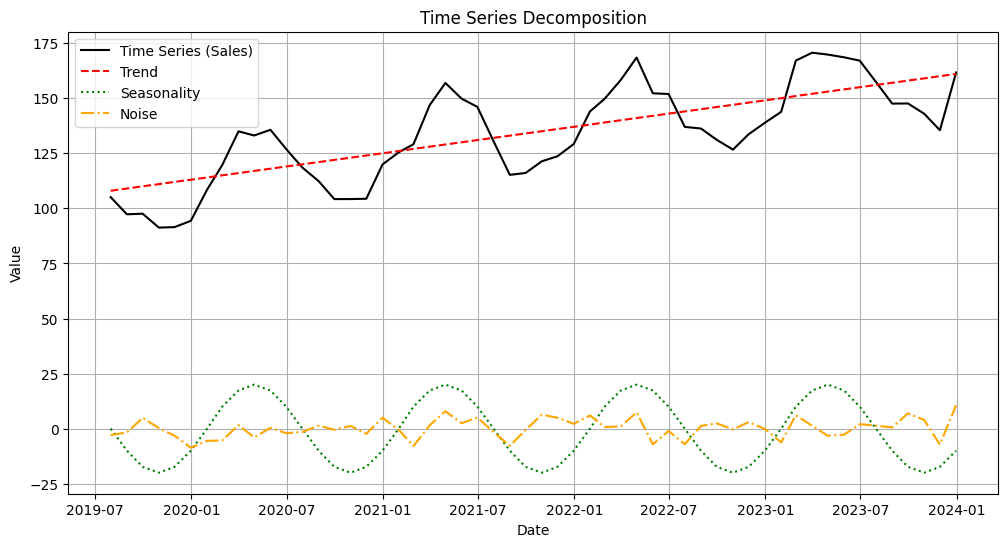

Train size: 26 | Test size: 27


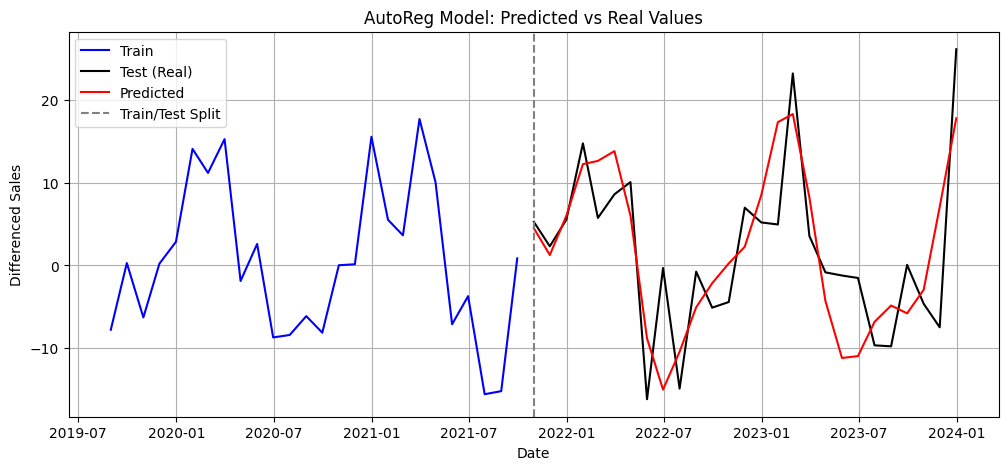

RMSE on Test Set: 6.7433


In [53]:
# ==========================================================
# 📘 Import libraries
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# ==========================================================
# 📊 Plot the time series decomposition
# ==========================================================
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Sales'], label='Time Series (Sales)', color='black')
plt.plot(df.index, df['Trend'], label='Trend', linestyle='--', color='red')
plt.plot(df.index, df['Seasonality'], label='Seasonality', linestyle=':', color='green')
plt.plot(df.index, df['Noise'], label='Noise', linestyle='-.', color='orange')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Decomposition')
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 🧮 Step 1: Make the series stationary (1st difference)
# ==========================================================
df['Sales_diff'] = df['Sales'].diff()
df = df.dropna()  # remove NaN created by differencing

# ==========================================================
# ✂️ Step 2: Split into train and test (80% / 20%)
# ==========================================================
y = df['Sales_diff']
train_size = int(len(y) * 0.5)
train, test = y[:train_size], y[train_size:]

print(f"Train size: {len(train)} | Test size: {len(test)}")

# ==========================================================
# 🤖 Step 3: Train the AutoReg model
# ==========================================================
model = AutoReg(train, lags=10)   # use 7 previous lags
model_fit = model.fit()

# ==========================================================
# 🔮 Step 4: Predict on the test period
# ==========================================================
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# ==========================================================
# 📈 Step 5: Plot Predicted vs Real values
# ==========================================================
plt.figure(figsize=(12, 5))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test (Real)', color='black')
plt.plot(test.index, predictions, label='Predicted', color='red')
plt.axvline(x=test.index[0], color='gray', linestyle='--', label='Train/Test Split')
plt.title('AutoReg Model: Predicted vs Real Values')
plt.xlabel('Date')
plt.ylabel('Differenced Sales')
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 📏 Step 6: Evaluate performance
# ==========================================================
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE on Test Set: {rmse:.4f}')


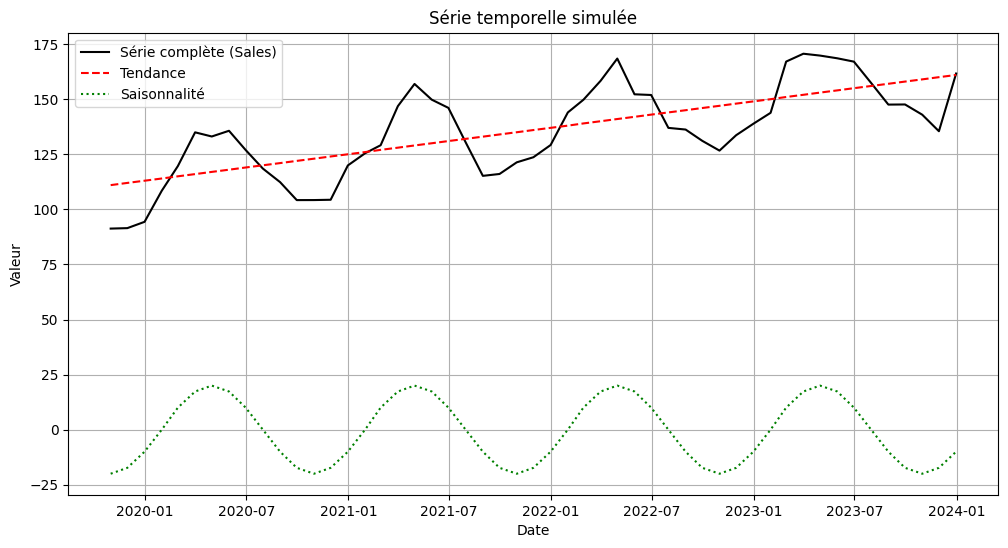

Train size: 25 | Test size: 25


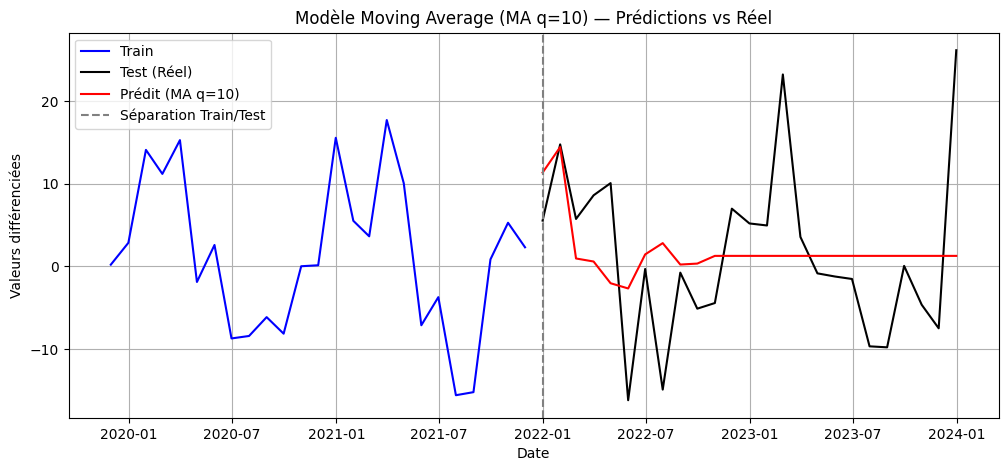

✅ RMSE du modèle MA(q=10) sur le jeu de test : 9.7569


In [56]:
# ==========================================================
# 📘 Import des librairies
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# ==========================================================
# 📊 Visualisation de la série initiale
# ==========================================================
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Sales'], label='Série complète (Sales)', color='black')
plt.plot(df.index, df['Trend'], '--', label='Tendance', color='red')
plt.plot(df.index, df['Seasonality'], ':', label='Saisonnalité', color='green')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.title('Série temporelle simulée')
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 🧮 Étape 1 : Rendre la série stationnaire (différenciation)
# ==========================================================
df['Sales_diff'] = df['Sales'].diff()
df = df.dropna()  # supprimer la première valeur NaN créée par la différence

# ==========================================================
# ✂️ Étape 2 : Split en train et test (80% / 20%)
# ==========================================================
y = df['Sales_diff']
train_size = int(len(y) * 0.5)
train, test = y[:train_size], y[train_size:]
print(f"Train size: {len(train)} | Test size: {len(test)}")

# ==========================================================
# 🤖 Étape 3 : Créer et entraîner le modèle Moving Average (MA)
# ==========================================================
q = 10  # ordre du MA
model_ma = ARIMA(train, order=(0, 0, q))  # (p=0, d=0, q=q)
model_ma_fit = model_ma.fit()

# ==========================================================
# 🔮 Étape 4 : Prédictions sur la période de test
# ==========================================================
predictions = model_ma_fit.predict(start=len(train), end=len(train)+len(test)-1)

# ==========================================================
# 📊 Étape 5 : Comparaison des valeurs réelles vs prédites
# ==========================================================
plt.figure(figsize=(12, 5))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test (Réel)', color='black')
plt.plot(test.index, predictions, label=f'Prédit (MA q={q})', color='red')
plt.axvline(x=test.index[0], color='gray', linestyle='--', label='Séparation Train/Test')
plt.title(f'Modèle Moving Average (MA q={q}) — Prédictions vs Réel')
plt.xlabel('Date')
plt.ylabel('Valeurs différenciées')
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 📏 Étape 6 : Évaluer la performance du modèle
# ==========================================================
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'✅ RMSE du modèle MA(q={q}) sur le jeu de test : {rmse:.4f}')

# ==========================================================
# 💡 Étape 7 (optionnelle) : Comparer plusieurs q pour choisir le meilleur
# ==========================================================
# print("\n🔍 Comparaison des valeurs AIC pour différents q :")
# for q in range(1, 6):
#     model = ARIMA(train, order=(0, 0, q)).fit()
#     print(f"q={q} → AIC = {model.aic:.2f}")


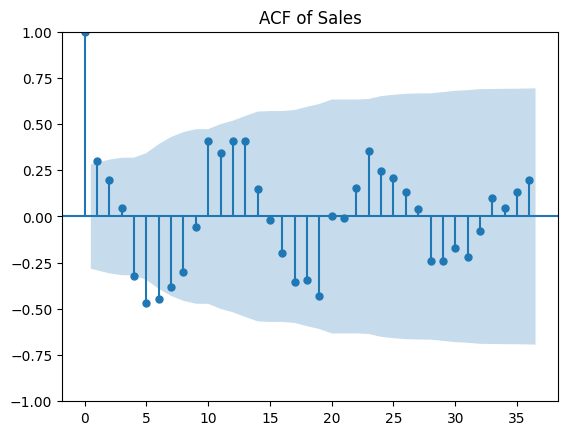

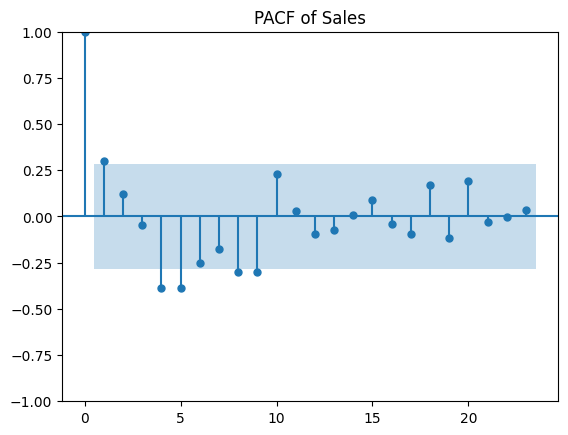

In [61]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
df['Sales_diff'] = df['Sales'].diff()
df = df.dropna()
# ACF plot
plot_acf(df['Sales_diff'], lags=36)
plt.title('ACF of Sales')
plt.show()

# PACF plot
plot_pacf(df['Sales_diff'], lags=23, method='ywm')
plt.title('PACF of Sales')
plt.show()


Train size: 43 | Test size: 11
                               SARIMAX Results                                
Dep. Variable:             Sales_diff   No. Observations:                   43
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -134.798
Date:                Mon, 27 Oct 2025   AIC                            281.595
Time:                        17:05:35   BIC                            292.162
Sample:                    07-31-2019   HQIC                           285.492
                         - 01-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9689      0.285      3.398      0.001       0.410       1.528
ar.L1          1.7044      0.045     38.267      0.000       1.617       1.792
ar.L2         -0.9696

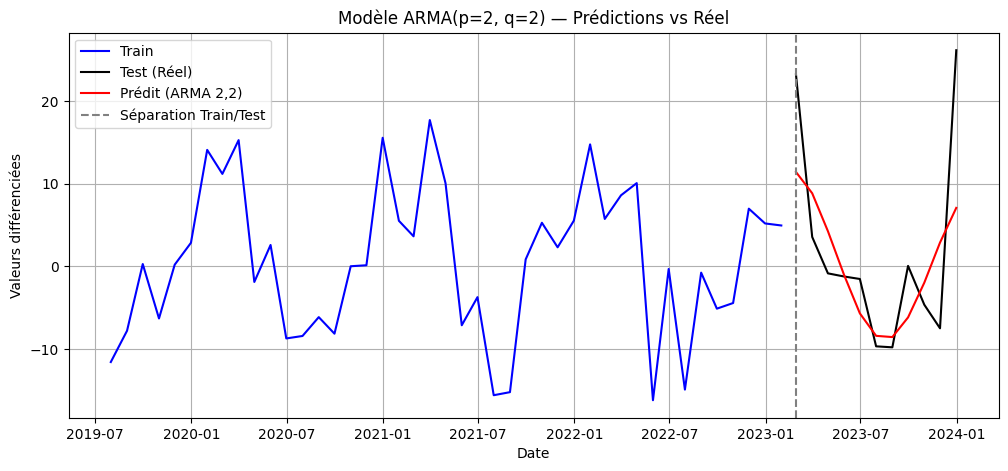

✅ RMSE du modèle ARMA(p=2, q=2) sur le jeu de test : 8.1651


In [51]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# ==========================================================
# 🧮 Étape 1 : S'assurer que la série est stationnaire
# ==========================================================
df['Sales_diff'] = df['Sales'].diff()
df = df.dropna()

# ==========================================================
# ✂️ Étape 2 : Split en train et test (80% / 20%)
# ==========================================================
y = df['Sales_diff']
train_size = int(len(y) * 0.8)
train, test = y[:train_size], y[train_size:]
print(f"Train size: {len(train)} | Test size: {len(test)}")

# ==========================================================
# 🤖 Étape 3 : Créer et entraîner le modèle ARMA
# ==========================================================
p = 2  # ordre AR
q = 2  # ordre MA
model_arma = ARIMA(train, order=(p, 0, q))  # ARMA(p,q) -> d=0
model_arma_fit = model_arma.fit()
print(model_arma_fit.summary())

# ==========================================================
# 🔮 Étape 4 : Prédictions sur la période de test
# ==========================================================
predictions = model_arma_fit.predict(start=len(train), end=len(train)+len(test)-1)

# ==========================================================
# 📊 Étape 5 : Comparaison des valeurs réelles vs prédites
# ==========================================================
plt.figure(figsize=(12, 5))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test (Réel)', color='black')
plt.plot(test.index, predictions, label=f'Prédit (ARMA {p},{q})', color='red')
plt.axvline(x=test.index[0], color='gray', linestyle='--', label='Séparation Train/Test')
plt.title(f'Modèle ARMA(p={p}, q={q}) — Prédictions vs Réel')
plt.xlabel('Date')
plt.ylabel('Valeurs différenciées')
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 📏 Étape 6 : Évaluer la performance du modèle
# ==========================================================
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'✅ RMSE du modèle ARMA(p={p}, q={q}) sur le jeu de test : {rmse:.4f}')


Train size: 43 | Test size: 11
                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   43
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -134.288
Date:                Mon, 27 Oct 2025   AIC                            278.576
Time:                        17:07:35   BIC                            287.264
Sample:                    07-31-2019   HQIC                           281.760
                         - 01-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7239      0.025     68.868      0.000       1.675       1.773
ar.L2         -0.9882      0.033    -30.165      0.000      -1.052      -0.924
ma.L1         -1.8250

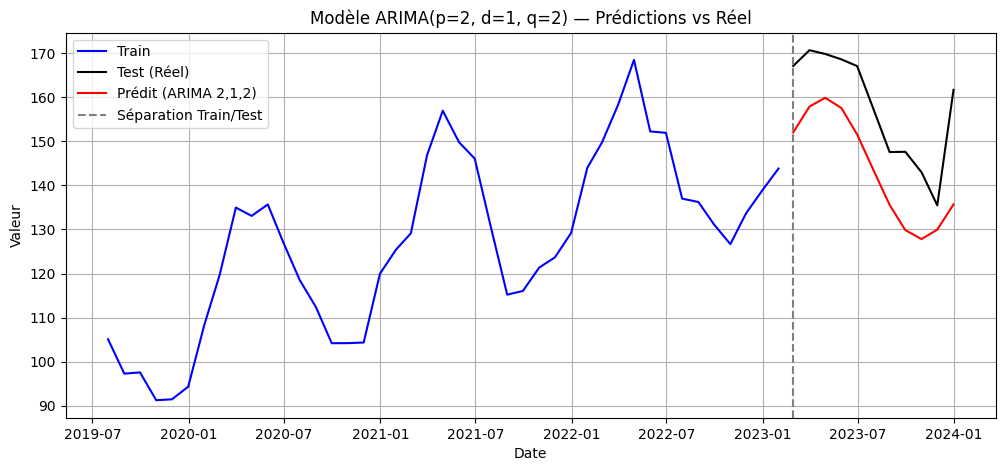

✅ RMSE du modèle ARIMA(p=2,d=1,q=2) sur le test : 14.8851


In [52]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# ==========================================================
# ✂️ Étape 1 : Split en train et test (80% / 20%)
# ==========================================================
y = df['Sales']
train_size = int(len(y) * 0.8)
train, test = y[:train_size], y[train_size:]
print(f"Train size: {len(train)} | Test size: {len(test)}")

# ==========================================================
# 🤖 Étape 2 : Créer et entraîner le modèle ARIMA
# ==========================================================
p = 2  # AR order
d = 1  # différenciation
q = 2  # MA order

model_arima = ARIMA(train, order=(p, d, q))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

# ==========================================================
# 🔮 Étape 3 : Prédictions sur la période de test
# ==========================================================
predictions = model_arima_fit.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')

# ==========================================================
# 📊 Étape 4 : Comparaison réel vs prédit
# ==========================================================
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test (Réel)', color='black')
plt.plot(test.index, predictions, label=f'Prédit (ARIMA {p},{d},{q})', color='red')
plt.axvline(x=test.index[0], color='gray', linestyle='--', label='Séparation Train/Test')
plt.title(f'Modèle ARIMA(p={p}, d={d}, q={q}) — Prédictions vs Réel')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 📏 Étape 5 : Évaluer la performance
# ==========================================================
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'✅ RMSE du modèle ARIMA(p={p},d={d},q={q}) sur le test : {rmse:.4f}')


Train size: 38 | Test size: 10
                                      SARIMAX Results                                       
Dep. Variable:                                Sales   No. Observations:                   38
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                 -32.815
Date:                              Mon, 27 Oct 2025   AIC                             79.631
Time:                                      17:30:46   BIC                             81.749
Sample:                                  01-31-2020   HQIC                            77.307
                                       - 02-28-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7902      1.361     -0.581      0.562      -3.458 

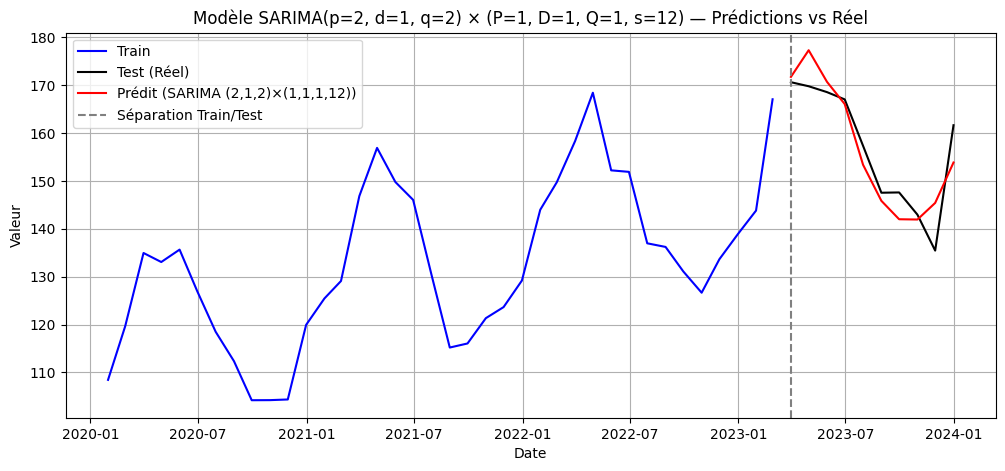

✅ RMSE du modèle SARIMA((2,1,2)×(1,1,1,12)) sur le test : 5.2371


In [64]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# ==========================================================
# ✂️ Étape 1 : Split en train et test (80% / 20%)
# ==========================================================
y = df['Sales']
train_size = int(len(y) * 0.8)
train, test = y[:train_size], y[train_size:]
print(f"Train size: {len(train)} | Test size: {len(test)}")

# ==========================================================
# 🤖 Étape 2 : Créer et entraîner le modèle SARIMA
# ==========================================================
p, d, q = 2, 1, 2        # ARIMA(p,d,q)
P, D, Q, s = 1, 1, 1, 12 # Saisonnalité (mensuelle ici)

model_sarima = SARIMAX(train,
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, s),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
model_sarima_fit = model_sarima.fit()
print(model_sarima_fit.summary())

# ==========================================================
# 🔮 Étape 3 : Prédictions sur la période de test
# ==========================================================
predictions = model_sarima_fit.predict(start=len(train),
                                       end=len(train)+len(test)-1,
                                       typ='levels')

# ==========================================================
# 📊 Étape 4 : Comparaison réel vs prédit
# ==========================================================
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test (Réel)', color='black')
plt.plot(test.index, predictions, label=f'Prédit (SARIMA ({p},{d},{q})×({P},{D},{Q},{s}))', color='red')
plt.axvline(x=test.index[0], color='gray', linestyle='--', label='Séparation Train/Test')
plt.title(f'Modèle SARIMA(p={p}, d={d}, q={q}) × (P={P}, D={D}, Q={Q}, s={s}) — Prédictions vs Réel')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 📏 Étape 5 : Évaluer la performance
# ==========================================================
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'✅ RMSE du modèle SARIMA(({p},{d},{q})×({P},{D},{Q},{s})) sur le test : {rmse:.4f}')
